# Import Libraries

In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, cv2, json
import opendatasets as od
import zipfile

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

### Downloads a source and unzip the zipped folder to a location on local drive 

In [3]:
od.download("https://www.kaggle.com/c/cassava-leaf-disease-classification/data?select=train.csv")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading cassava-leaf-disease-classification.zip to ./cassava-leaf-disease-classification


100%|██████████| 5.76G/5.76G [14:42<00:00, 7.01MB/s] 



Extracting archive ./cassava-leaf-disease-classification/cassava-leaf-disease-classification.zip to ./cassava-leaf-disease-classification


Sometimes data is stored in a zip folder in side a zip folder. In this case we use the `od.download()` method to download a folder and unzip the zipped folder but the folder inside the zipped folder should be latter on unzipped with `zipfile.ZipFile(<origin>, 'r') and alias.extractall(<destination>)`

In [5]:
od.download('https://www.kaggle.com/c/cassava-disease/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading cassava-disease.zip to ./cassava-disease


100%|██████████| 2.30G/2.30G [05:33<00:00, 7.42MB/s]



Extracting archive ./cassava-disease/cassava-disease.zip to ./cassava-disease


### Unzip zipped file which is already downloaded from a source

In [3]:

with zipfile.ZipFile("/Users/paulosgidyelew/Desktop/cassava-classification-capstone/notebooks/cassava-disease/train.zip", 'r') as zip_file:
    zip_file.extractall("../data")

In [292]:
file_path = '../data/'

In [293]:
pwd = file_path+'train'
os.listdir(pwd)

['cgm', 'cmd', 'healthy', 'cbb', 'cbsd']

In [294]:
cbb = os.path.join(file_path+'train/cbb')
cbsd = os.path.join(file_path+'train/cbsd')
cgm = os.path.join(file_path+'train/cgm')
cmd = os.path.join(file_path+'train/cmd')
healthy = os.path.join(file_path+'train/healthy')

In [295]:
train_json = {key:value for key,value in zip(['cbb',
                                            'cbsd',
                                            'cgm',
                                            'cmd',
                                            'healthy'],
                                            [os.listdir(cbb),
                                            os.listdir(cbsd),
                                            os.listdir(cgm),
                                            os.listdir(cmd),
                                            os.listdir(healthy)])}
data1 = pd.DataFrame(train_json['cbb'],columns=['image'])
data2 = pd.DataFrame(train_json['cbsd'],columns=['image'])
data3 = pd.DataFrame(train_json['cgm'],columns=['image'])
data4 = pd.DataFrame(train_json['cmd'],columns=['image'])
data5 = pd.DataFrame(train_json['healthy'],columns=['image'])

In [296]:
data1['label'] = 0
data2['label'] = 1
data3['label'] = 2
data4['label'] = 3
data5['label'] = 4

In [297]:
data = pd.concat([data1,data2,data3,data4,data5])
data.sample(5)

,image,label
634,train-cmd-2535.jpg,3
1151,train-cmd-560.jpg,3
1281,train-cmd-1922.jpg,3
19,train-cbb-371.jpg,0
1075,train-cmd-1666.jpg,3


In [298]:
labels_dict = {
                0:'CBB',
                1:'CBSD',
                2:'CGM',
                3:'CMD',
                4:'Healthy'
                }

In [299]:
json.dump(labels_dict, open(file_path+'label_dict.json', 'w'))

In [300]:
with open(file_path+'label_dict.json') as file:
    str_labels = json.load(file)
    str_labels = {int(k):v for k,v in str_labels.items()}
data['label_name'] = data.label.map(str_labels)

In [301]:
data.head()

,image,label,label_name
0,train-cbb-166.jpg,0,CBB
1,train-cbb-172.jpg,0,CBB
2,train-cbb-199.jpg,0,CBB
3,train-cbb-358.jpg,0,CBB
4,train-cbb-364.jpg,0,CBB


In [302]:
data.shape

(5656, 3)

In [310]:
data.to_csv(file_path+'train.csv',index=False)

In [304]:
data.label_name = data.label_name.astype(str).astype('category')

In [305]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5656 entries, 0 to 315
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   image       5656 non-null   object  
 1   label       5656 non-null   int64   
 2   label_name  5656 non-null   category
dtypes: category(1), int64(1), object(1)
memory usage: 138.3+ KB


### The different classes of the cassava leaf images

In [306]:
data.label_name.unique()

['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']
Categories (5, object): ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']

##### The following plot shows data distribution of the classes. As we can see the dataset is imbalanced with CMD being the majority class.

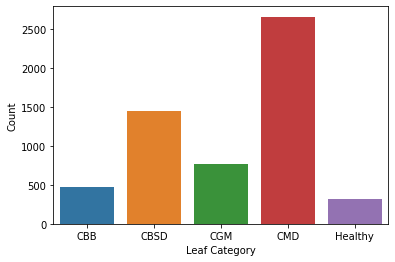

In [307]:
sns.countplot(data = data, x=data.label_name)
plt.xlabel('Leaf Category')
plt.ylabel('Count')
plt.show()


##### Data distribution among the four classes in a data frame   

In [308]:
data_len = [i for i in [len(os.listdir(cbb)),
                        len(os.listdir(cbsd)),
                        len(os.listdir(cgm)),
                        len(os.listdir(cmd)),
                        len(os.listdir(healthy))]]
dict = {key: value for key, value in zip(['cbb','cbsd','cgm','cmd','healthy'],data_len)}
data_info =pd.DataFrame(dict,index=['Count'])
total = pd.DataFrame({'total':len(data)},index=['Count'])
total.columns = ['total']
data_info=pd.concat([data_info,total],axis=1)
data_info


,cbb,cbsd,cgm,cmd,healthy,total
Count,466,1443,773,2658,316,5656


##### Save data frame as csv file in local drive for reuse

In [312]:
data_info.to_csv(file_path+'data_info.csv',index=False)

##### Creating a data frame of pixel values of the image data for further analysis

In [22]:
path = '../data/train/'

In [23]:
sample = data[data.label_name == 'CMD']
pxls,labels = [],[]
for idx, (img_id, label) in enumerate(zip(sample.image, sample.label)):
    image = cv2.imread(os.path.join(path, "cmd", img_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pxls.append(image.shape)
    labels.append(img_id)

In [24]:
pxl = {label: pxl for label, pxl in  zip(labels,pxls)} 
pxl_frame = pd.DataFrame({'cmd_img':labels,'dpi':pxls}) 
pxl_frame.head()

,cmd_img,dpi
0,train-cmd-1992.jpg,"(500, 500, 3)"
1,train-cmd-2243.jpg,"(500, 666, 3)"
2,train-cmd-2525.jpg,"(500, 500, 3)"
3,train-cmd-1038.jpg,"(666, 500, 3)"
4,train-cmd-2531.jpg,"(500, 594, 3)"


In [25]:
pxl_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cmd_img  2658 non-null   object
 1   dpi      2658 non-null   object
dtypes: object(2)
memory usage: 41.7+ KB


# Pixel size of each image in the dataset

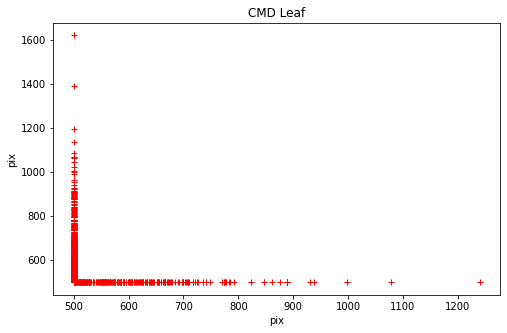

In [31]:
fig = plt.figure(figsize=(8,5))
x = [x[0] for x in pxl_frame.dpi]
y = [x[1] for x in pxl_frame.dpi]
plt.plot(x,y,'r+')
plt.xlabel('pix')
plt.ylabel('pix')
plt.title('CMD Leaf')
plt.show()

##### Random Images of class CMD for visual analysis

In [ ]:
sample = data[data.label_name == 'CMD'].sample(9)
fig, ax = plt.subplots(int(np.ceil(len(sample)/3)),3,figsize=[15, 20])
ax = ax.ravel()
for idx, img_id in enumerate(sample.image):
    image = cv2.imread(os.path.join(path, "cmd", img_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,dsize=(300,300))
    ax[idx].set_title(img_id.split('-')[1])
    ax[idx].imshow(image)
    ax[idx].axis('off')
plt.tight_layout()
plt.show()

# Color spaces in Image Processing

<p style='text-align: justify'>In images processing algorithms one can use various colour spaces based on the better fits to the purpose of the application. These color spaces include RGB, VHS, LAB, HSI and Y'CbCr colour spaces.<br>Colors can provide relevant information in image processing applications like classification of cassava leaves as healthy or unhealthy to identify important edges or other features. For instance, if there is an edge (a step change in pixel value) in hue that is hard to detect in a gray-scale image, or if we need to identify objects of known hue (yellowish or orange color of sick plant leaf and green leaves of healthy cassava plant), color information is useful. If we don't need color, then we can consider it as noise and we can go for the single channel gray-scale image in our algorithm.Thus, in our image classification algorithm, we are going to use RGB color space,however, processing multi channel images comes with its costs:</p>

<ol>

<li>Computational Speed: 

<p style='text-align: justify'>With parallel computing capabilities of modern computers, it's possible to perform simple pixel-by-pixel processing of a megapixel image in milliseconds. However, whatever processing time is required to manipulate the image or pool some useful data from it, cost still will be higher compared to one channel (gray-scale) image processing. If we make the rule-of-thumb assumption, processing a three-channel color image, such that in the RGB color space, it takes three times or maybe longer as long as processing a gray-scale image, since we may create a separate luminance channel (luma is a mix of about 60% green, 30% red and 10% blue).</p></li>

<li>Difficulty to Visualize:

<p style='text-align: justify'>In RGB, HSI, Lab, and other color spaces visualization is much harder since there are additional dimensions that the standard human brain can't comprehend.</p></li>

<li>Complexity in modeling:

<p style='text-align: justify'>Finding edges and features based on luminance and chrominance will add complexity to the image processing model (luminance represents the brightness in an image, while the chrominance represent the color information). In multi-channel images processing, detail perception is obtained from the luminance component of each pixel almost exclusively, because the human vision system is not well suited to detect structures defined by varying chrominance values.</p></li>

</ol>

In [ ]:
sample = data[data.label_name == 'CMD'].sample(9)
plt.figure(figsize=(10, 8))
pixel_values =[]
for idx, (img_id, label) in enumerate(zip(sample.image, sample.label_name)):
    image = cv2.imread(os.path.join(path, "cmd", img_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,dsize=(300,300))
    pixel_values.append(image[:,:,0][0])
    plt.subplot(2,2,1)
    plt.imshow(image)
    plt.title(label+' -'+' '+'color: RGB')
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(image[:,:,0], cmap='Reds')
    plt.title(label+' -'+' '+'color: Red')
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(image[:,:,1], cmap='Greens')
    plt.title(label+' -'+' '+'color: Green')
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(image[:,:,2], cmap='Blues')
    plt.title(label+' -'+' '+'color: Blue')
    plt.axis('off')
plt.tight_layout()
plt.show()

><p style='text-align: justify; color: blue'>The following pixel values are only one axis (300 pixels out of 90,000 pixels) of the red channel of the image and the values are between 0 and 255 where 0 is for absolutely <b>black</b> and 255 for absolutely <b>white</b>. In other words, the smaller the closer the number to 0 the darker the shade while the closer the number to 255 the lighter or the whiter the shade. The red channel of the image contains about 300x300 pixels alone for the three channels will be a multiple of 3 of that figure.</p>

In summary:

+ Images are stored in the form of a matrix or tensor, where these numerical values in these matrix are known as ixel  values.
+ These pixel values represent the intensity of each pixel.
+ Zero represents black and 255 represents white.
+ The matrix is known as the channel and in the case of a gray-scale image, we have only one channel and in RGB we have three channels.
+ In single channel we need only one byte or `8 bits unsigned integers` of storage for each pixel and for three channels we need 3bytes for each pixel.

In [223]:
pixel_values[0]

array([185, 235, 207, 218, 214, 229, 217, 163, 184, 188, 167, 210, 208,
       201, 179, 207, 109, 127, 156, 139, 157, 185, 205, 113, 155, 146,
       161, 184, 179, 194, 242, 196, 196, 191, 191, 137,  95, 182, 128,
       100,  68,  65, 128, 100,  92,  80,  73,  65,  60,  53,  49,  45,
        42,  44,  54,  49,  52,  49,  44,  43,  45,  45,  44,  41,  50,
        59,  64,  65,  58,  55,  61,  82, 119, 144, 103,  75,  92, 159,
       185, 188, 184, 170, 133,  71,  39,  34,  28,  27,  25,  23,  27,
        30,  31,  33,  34,  38,  47,  55,  55,  52,  48,  47,  47,  49,
        52,  50,  61,  64,  63,  52,  36,  27,  23,  20,  19,  20,  22,
        25,  26,  25,  25,  25,  31,  36,  51,  53,  40,  43,  46,  48,
        52,  53,  59,  54,  34,  31,  31,  39,  39,  37,  32,  48,  53,
        43,  40,  41,  37,  32,  33,  35,  37,  35,  35,  34,  39,  41,
        45,  43,  37,  37,  33,  31,  28,  30,  31,  32,  33,  33,  38,
        37,  31,  28,  23,  21,  21,  25,  27,  27,  28,  29,  2

# Color Maps

<table>
    <tr>
        <th>color map</th>
        <th>description</th>
    </tr>
    <tr>
        <td>hsv</td>
        <td>cyclic red-yellow-green-cyan-blue-magenta-red, formed by changing the hue component in the HSV color space</td>  
    </tr>
    <tr>
        <td>bwr</td>	
        <td>diverging blue-white-red</td>
    </tr>
    <tr>
        <td>gray	</td>	
        <td>sequential linearly-increasing black-to-white gray-scale</td>
    </tr>
</table>

Source: [Kite](https://www.kite.com/python/docs/matplotlib.pyplot.colormaps)

In [ ]:
sample = data[data.label_name == 'CMD'].sample(9)
plt.figure(figsize=(10, 8))

for idx, (img_id, label) in enumerate(zip(sample.image, sample.label_name)):
  
    image = cv2.imread(os.path.join(path, "cmd", img_id))
    image=cv2.cvtColor(image,cv2.COLOR_BGR2LAB)
    plt.subplot(2,2,1)
    plt.imshow(image)
    plt.title(label+'-'+' '+'color: LAB')
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.title(label+'-'+' '+'color: gray')
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(image[:,:,1], cmap='hsv')
    plt.title(label+'-'+' '+'color: hsv')
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(image[:,:,2], cmap='bwr')
    plt.title(label+'-'+' '+'color: bwr')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Laplacian Transformation:

Our dataset contains partly poor quality images. We need to find a solution to filter out these images from our dataset, since they will negatively impact the accuracy of our model. The laplace transform function is used to resolve this problem. In the following we will try to explain how this function would be applied and how it works.

Laplace filtering method used to identify and highlight fine edges based on the 2nd derivative.

`OpenCV.Laplacian(gray_img, ksize, scale)` returns filtered image

Parameters:

gray_img - Grayscale image data
ksize - apertures size used to calculate 2nd derivative filter, specifies the size of the kernel (must be an odd integer: 1,3,5...)
scale - scaling factor applied (multiplied) to computed Laplacian values (scale = 1 is unscaled)

Context:

It is used to define edges around objects. The function calculates the Laplacian of the source image by adding up the second x and y derivatives calculated using the Sobel operator:

$Laplace(f) = \dfrac{\partial^{2} f}{\partial x^{2}} + \dfrac{\partial^{2} f}{\partial y^{2}}$

When ksize = 1, the Laplacian is computed by filtering the image with the following 3×3 aperture:

$\begin{bmatrix}
0 & 1 & 0\\
1 & -4 & 1\\
0 & 1 & 0 
\end{bmatrix}$


<p style="text-align: justify">Function described in this section is used to perform linear or non-linear filtering operations on 2D images. It means that for each pixel location (x, y) in the source image (normally, rectangular), its neighborhood is considered and used to compute the response. In case of a linear filter, it is a weighted sum of pixel values. In case of morphological operations, it is the minimum or maximum values, and so on. The computed response is stored in the destination image at the same location (x, y). It means that the output image will be of the same size as the input image. Normally, the functions support multi-channel arrays, in which case every channel is processed independently. Therefore, the output image will also have the same number of channels as the input one.</p>

Depth combinations:

|Input depth (src.depth())	|Output depth (ddepth)|
|---|---|
|CV_8U	|-1/CV_16S/CV_32F/CV_64F|
|CV_16U/CV_16S	|-1/CV_32F/CV_64F|
|CV_32F	|-1/CV_32F/CV_64F|
|CV_64F	|-1/CV_64F|

<p style="text-align: justify">OpenCV BGR or Gray_scale images have pixel values from 0 to 255 when in CV_8U - corresponds to np.uint8. When we use the Laplacian transform with ddepth (desired depth of the destination image), we set it to OpenCV.CV_32F or OpenCV.CV_64F.</p> 

For more details [click here](https://docs.opencv.org/4.1.0/d4/d86/group__imgproc__filter.html#filter_depths)

In [36]:
import glob

def laplacian(threshold, path):
    bad_img,lap_val = [],[]
    for img in glob.glob(path):
        image = cv2.imread(img)
        img_gry = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
        lap_var = cv2.Laplacian(img_gry,cv2.CV_32F,ksize=1).var()
        if lap_var < threshold:
            bad_img.append(img)
            lap_val.append(lap_var)
    bad_img_dict = {img:val for img,val in zip(bad_img,lap_val)}
    return bad_img_dict

bad_img_dict = laplacian(75, "../data/cassava-disease/train/cbb/*.jpg")

In [37]:
bad_img_lap = [i.split('/')[5] for i in bad_img_dict.keys()]
lap_val = bad_img_dict.values()
bad_img_S = pd.Series(bad_img_lap)
lap_var_S = pd.Series(lap_val)

bad_img_frm = pd.concat([bad_img_S,lap_var_S],axis=1)
bad_img_frm.columns = ['image_id','laplacian_var']
bad_img_frm.head()

,image_id,laplacian_var
0,train-cbb-365.jpg,27.239807
1,train-cbb-167.jpg,65.157829
2,train-cbb-399.jpg,54.976665
3,train-cbb-311.jpg,33.626156
4,train-cbb-263.jpg,51.409893


In [ ]:
# plot blurry images of class "cbb"

def laplacian_plot(rows=4,cols=4):
    fig, ax = plt.subplots(int(np.ceil(len(bad_img_dict.keys())/cols)),rows,figsize=[15, 20])
    ax = ax.ravel()
    for idx, img in enumerate(bad_img_dict.keys()):
        image = cv2.imread(img)
        image = cv2.resize(image,dsize=(250,250))
        ax[idx].set_title(img.split('/')[5])
        ax[idx].axis('off')
        ax[idx].imshow(image)
        plt.tight_layout()
    plt.show()
    return
laplacian_plot()

# 3D Visualization of RGB Image

 In RGB, HSI, Lab, and other color spaces, visualization is difficult since there are additional dimensions that the standard human brain can't comprehend. The following 3D map shows how the tensor of a 3 channel image look like. The x, y and z axes represent pixel values in their respective axes between 0 and 255 as 8 bit unsigned integers.

In [ ]:
image = cv2.imread(os.path.join(path,bad_img_frm.image_id[0].split('-')[1]+'/'+bad_img_frm.image_id[0]))
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.resize(image,dsize=(300,300))

fig = plt.figure(figsize=(25,20))

# First subplot
ax = fig.add_subplot(2, 1, 1, projection='3d')
ax.set_title('3D color space of an image in RGB scale',fontsize=16)
y = range( image.shape[0] )
x = range( image.shape[1] ) 
X, Y = np.meshgrid(x, y)
ax.plot_surface(X, Y, image[:,:,2])

# Second subplot
ax = fig.add_subplot(2, 3, 3)
ax.set_title('Image in  RGB color space', fontsize=16)
ax.imshow(image)
ax.axis('off')
plt.show()